<a href="https://colab.research.google.com/github/DazhiZhong/Pixray_Notebooks/blob/main/Pixray_Zoom_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pixray zooming demo
Using pixray to zooom! Demo made with love by <a href="https://github.com/DazhiZhong">Dazhi Zhong</a>.



In [12]:
#@title demo video
from moviepy.editor import *
clip=VideoFileClip('sample_by_dazhizhong.mp4')
clip.ipython_display(width=430)

 99%|█████████▉| 150/151 [00:00<00:00, 338.75it/s]


In [ ]:
#@title Setup

#@markdown Please execute this cell by pressing the _Play_ button 
#@markdown on the left. For setup,
#@markdown **you need to run this cell,
#@markdown then choose Runtime -> Restart Runtime from the menu,
#@markdown and then run the cell again**. It should remind you to
#@markdown do this after the first run.

#@markdown Setup can take 5-10 minutes, but once it is complete it usually does not need to be repeated
#@markdown until you close the window.

#@markdown **Note**: This installs the software on the Colab 
#@markdown notebook in the cloud and not on your computer.

# https://stackoverflow.com/a/56727659/1010653

# Add a gpu check
# (this can get better over time)
from google.colab import output

nvidia_output = !nvidia-smi --query-gpu=memory.total --format=noheader,nounits,csv
gpu_memory = int(nvidia_output[0])
if gpu_memory < 14000:
  output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')
  warning_string = f"--> GPU check: ONLY {gpu_memory} MiB available: WARNING, THIS IS PROBABLY NOT ENOUGH <--"
  print(warning_string)
  output.eval_js('alert("Warning - low GPU (see message)")')
else:
  print(f"GPU check: {gpu_memory} MiB available: this should be fine")

from IPython.utils import io
with io.capture_output() as captured:
  # On 2021/10/08, Colab updated its default PyTorch installation to a version that causes
  # problems with diffvg. So, first thing, let's roll back to the older version:
  !pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch/ -f https://download.pytorch.org/whl/torchvision/

  !git clone https://github.com/openai/CLIP
  # !pip install taming-transformers
  !git clone https://github.com/CompVis/taming-transformers.git
  !rm -Rf pixray
  !git clone https://github.com/dribnet/pixray
  !pip install ftfy regex tqdm omegaconf pytorch-lightning
  !pip install kornia
  !pip install imageio-ffmpeg   
  !pip install einops
  !pip install torch-optimizer
  !pip install easydict
  !pip install braceexpand
  !pip install git+https://github.com/pvigier/perlin-numpy

  # ClipDraw deps
  !pip install svgwrite
  !pip install svgpathtools
  !pip install cssutils
  !pip install numba
  !pip install torch-tools
  !pip install visdom

  !git clone https://github.com/BachiLi/diffvg
  %cd diffvg
  # !ls
  !git submodule update --init --recursive
  !python setup.py install
  %cd ..

output.clear()
import sys
import shutil
import numpy as np
from PIL import ImageFile, Image, PngImagePlugin
sys.path.append("pixray")

def zoom_at(img, w, h, bias=(0,0)):
    x, y = img.size
    bx,by = bias
    img = img.crop((  w+bx,  h+by, 
                    x-w+bx, y-h+by))
    return img.resize((x, y), Image.LANCZOS)

def make_seed_img(from_fn, to_fn='cur_seed.png', rot = 5, enl = 10, bias = (0,0)):
    in_img = Image.open(from_fn)
    seed_img_array = np.ones((in_img.size[1],in_img.size[0],3)) * 255
    seed_img = Image.fromarray(seed_img_array.astype('uint8')).convert('RGBA')
    in_img = zoom_at(in_img, enl,enl,bias) 
    in_img = in_img.rotate(rot, 3, fillcolor='white')
    in_img.save(to_fn)

result_msg = "setup complete"
import IPython
import os
if not os.path.isfile("first_init_complete"):
  # put stuff in here that should only happen once
  !mkdir -p models
  os.mknod("first_init_complete")
  result_msg = "Please choose Runtime -> Restart Runtime from the menu, and then run Setup again"

js_code = f'''
document.querySelector("#output-area").appendChild(document.createTextNode("{result_msg}"));
'''
js_code += '''
for (rule of document.styleSheets[0].cssRules){
  if (rule.selectorText=='body') break
}
rule.style.fontSize = '30px'
'''
display(IPython.display.Javascript(js_code))

<IPython.core.display.Javascript object>

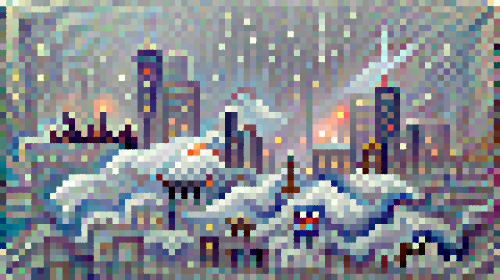

iter: 200, finished (-13=>2.207)


'./very_first_frame.png'

In [ ]:
#@title First Frame Settings

#@markdown Enter a description of what you want to draw - I usually add #pixelart to the prompt.
#@markdown If PixelDraw is not used, it will use VQGAN instead.
#@markdown <br>

prompts = "snowstorm above the cityscape #pixelart #8bit" #@param {type:"string"}

aspect = "widescreen" ##param ["widescreen", "square"]

do_pixel = True #@param {type:"boolean"}

#@markdown Specify the desired palette ("" for default), here's a few examples:
#@markdown * red     (16 color black to red ramp)
#@markdown * rust\8  (8 color black to rust ramp)
#@markdown * black->red->white (16 color black/red/white ramp)
#@markdown * [#000000, #ff0000, #ffff00, #000080] (four colors)
#@markdown * red->yellow;[black]     (16 colors from ramp and also black)
#@markdown * Named colors can be anything in <a target=”_blank” href="https://xkcd.com/color/rgb/">this lookup table</a>

use_palette = "[#000000, #071008, #0e2011, #153019, #1c4022, #23502a, #2a6033, #31703b, #388044, #3f8f4c, #469f54, #4daf5d, #54bf65, #5bcf6e, #62df76, #69ef7f];black->white" #@param {type:"string"}
#@markdown Use this flag to encourage smoothess:
smoothness = True #@param {type:"boolean"} 

#@markdown Use this flag to encourage color saturation (use it against color fading):
saturation = True #@param {type:"boolean"} 

#@markdown When you have the settings you want, press the play button on the left.
#@markdown The system will save these and start generating images below.

#@markdown When that is done you can change these
#@markdown settings and see if you get different results. Or if you get
#@markdown impatient, just select "Runtime -> Interrupt Execution".
#@markdown Note that the first time you run it may take a bit longer
#@markdown as nessary files are downloaded.


#@markdown
#@markdown *Advanced: you can also edit this cell and add add additional
#@markdown settings, combining settings from different notebooks.*


# Simple setup
import pixray

# these are good settings for pixeldraw
pixray.reset_settings()
pixray.add_settings(prompts=prompts, aspect=aspect)
pixray.add_settings(quality="better", scale=2.5)
pixray.add_settings(display_clear=True)

if do_pixel:
  pixray.add_settings(drawer="pixel")

# palette = None
if use_palette and use_palette!='None':
  pixray.add_settings(target_palette=use_palette)

if smoothness and smoothness!='None':
  pixray.add_settings(smoothness=2.0, smoothness_type='log')

if saturation:
  pixray.add_settings(saturation=1.0)

pixray.add_settings(noise_prompt_seeds=[1,2,3])

#### YOU CAN ADD YOUR OWN CUSTOM SETTING HERE ####
# this is the example of how to run longer with less frequent display
# pixray.add_settings(iterations=200, display_every=50)

settings = pixray.apply_settings()
pixray.do_init(settings)
pixray.do_run(settings)

shutil.copy('./output.png', './very_first_frame.png')

In [ ]:
#@title remove all existing frames
import glob
frms = glob.glob("frame*.png")
_ = [os.remove(i) for i in frms]

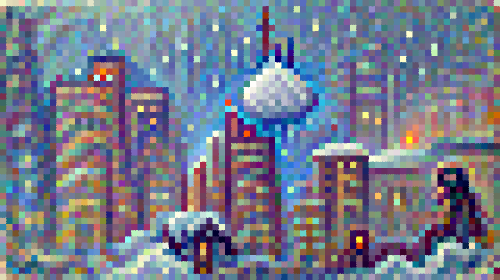

iter: 30, finished (-5=>2.157)


'./frame_020.png'

In [ ]:
#@title Make sure you like the first frame, then start this cell to generate all other frames:
#@markdown change total_frame_num for longer videos! 
#@markdown increase run_iters for better quality results
shutil.copy('./very_first_frame.png', f'./frame_{0:03d}.png')


total_frame_num =  20#@param{type: "number"}

run_iters =  30#@param{type: "number"}
display_every = 30#@param{type: "number"}
rotation_angle = 1#@param{type: "number"}
zoom_pixels = 10#@param{type: "number"}

for frame in range(total_frame_num):
    shutil.copy('./output.png', f'./frame_{frame:03d}.png')
    make_seed_img(f'./frame_{frame:03d}.png', rot=rotation_angle, enl=zoom_pixels)
    pixray.reset_settings()
    pixray.add_settings(prompts=prompts, aspect=aspect)
    pixray.add_settings(quality="better", scale=2.5)
    pixray.add_settings(display_clear=True)
    pixray.add_settings(init_image='./cur_seed.png')
    pixray.add_settings(iterations=run_iters, display_every=display_every)
    if do_pixel:
      pixray.add_settings(drawer="pixel")
    # palette = None
    if use_palette and use_palette!='None':
      pixray.add_settings(target_palette=use_palette)
    if smoothness and smoothness!='None':
      pixray.add_settings(smoothness=2.0, smoothness_type='log')
    if saturation:
      pixray.add_settings(saturation=1.0)
    pixray.add_settings(noise_prompt_seeds=[1,2,3])  

    settings = pixray.apply_settings()
    pixray.do_init(settings)
    pixray.do_run(settings)

shutil.copy('./output.png', f'./frame_{frame+1:03d}.png')

In [ ]:
#@title make video from steps
from moviepy.editor import *
import cv2
import numpy as np
import glob
import os
from tqdm.notebook import tqdm
from PIL import Image

init_frame =  0#@param  {type: "number"}
last_frame = total_frame_num  #@param 
fps =  8#@param {type: "number"}
video_name = "output_video.mp4" #@param {type: "string"}
total_frames = last_frame-init_frame

# video runtime in seconds
length = total_frames*fps

frames = []
for i in tqdm(range(init_frame,last_frame)): #
    filename = f"frame_{i:03}.png"
    if os.path.isfile(filename):
        frames.append(cv2.imread((filename)))
    else:
        print('missing',i)

height, width, layers = cv2.imread(f"frame_000.png").shape
size = (width,height)
out = cv2.VideoWriter(video_name,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
 
for i in tqdm(frames):
    out.write(i)
out.release()

clip=VideoFileClip(video_name)
clip.ipython_display(width=580)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 95%|█████████▌| 20/21 [00:00<00:00, 270.62it/s]
